In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (7,5)
import seaborn as sns
colors = sns.color_palette("colorblind")

In [2]:
# Define custom dash patterns for each line without names
custom_dashes = [
    (1, 0),           # Solid
    (1, 1),           # Dotted
    (4, 2),           # Dashed
    (3, 2, 1, 2),     # Dash-Dot
    (5, 2, 1, 2, 1, 2),  # Dash-Dot-Dot
    (8, 2),           # Long Dashes
    (2, 4),           # Loosely Dashed
    (5, 4, 1, 4),     # Sparse Dash-Dot
    (6, 4, 1, 4, 1, 4),  # Sparse Dash-Dot-Dot
    (1, 4),           # Loosely Dotted
    (4, 2, 1, 2, 1, 2),  # Dashed with Dots
    (2, 4, 1, 4, 2, 4)   # Custom Pattern 1
]

In [3]:
def lossBilinear(x, y, loss_param):
    B = loss_param[0]
    return jnp.dot(jnp.dot(x, B), y)

def lossBilinearFull(x, y, loss_param):
    A = loss_param[0]
    B = loss_param[1]
    C = loss_param[2]
    return 0.5*jnp.dot(jnp.dot(x, A), x) + jnp.dot(jnp.dot(x, B), y) - 0.5*jnp.dot(jnp.dot(y, C), y)

def lossHighNonlinear_1(x, y, loss_param):
    return jnp.sum(x*(y-0.45) + phi_1(x) - phi_1(y))

def phi_1(z):
    return 0.25*jnp.power(z, 2) - 0.5*jnp.power(z, 4)  + (1/6)*jnp.power(z, 6)

def lossHighNonlinear_2(x, y, loss_param):
    epsilon = loss_param[0]
    return jnp.sum(x*y - epsilon*phi_2(y))

def phi_2(z):
    return 0.5*jnp.power(z, 2) - 0.25*jnp.power(z, 4)

def lossHighNonlinear_3(x, y, loss_param):
    return jnp.sum(x*y + phi_3(x) - phi_3(y))

def phi_3(z):
    return 0.5*jnp.power(z, 2) - 0.25*jnp.power(z, 4)  + (1/6)*jnp.power(z, 6) - (1/8)*jnp.power(z, 8)

def many_norm_iterates(x, y):
    norm_iteratess = np.zeros((np.shape(x)[0],np.shape(x)[1]))
    for i in range(0,np.shape(x)[0]):
        norm_iteratess[i,:] = (np.linalg.norm(x[i,:,:],axis=1)**2 + np.linalg.norm(y[i,:,:],axis=1)**2)/2.0

    return norm_iteratess

In [4]:
def SEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed):
    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))


    x = x_init
    y = y_init

    d = x_init.shape[0]

    trajectory_x = [x]
    trajectory_y = [y]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y

        increment_x = grad_loss_x(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_x
        increment_y = grad_loss_y(x - rho*(grad_x), y + rho*(grad_y), loss_param) + Z_y

        x = x - eta * increment_x
        y = y + eta * increment_y

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


def SHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range(num_iterations):

        np.random.seed((k+1)*seed)
        Z_x = sigma*jnp.array(np.random.normal(size=(d,)))
        Z_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param) + Z_x
        grad_y = grad_loss_y(x, y, loss_param) + Z_y
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        x = x - eta * (jnp.dot(hess_xx,grad_x) + jnp.dot(hess_xy,grad_y))
        y = y - eta * (jnp.dot(hess_xy,grad_x) + jnp.dot(hess_yy,grad_y))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x, trajectory_y


In [5]:
def SDE_SEG(loss, loss_param, x_init, y_init, eta, res, rho, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))


    x = x_init
    y = y_init

    d = x_init.shape[0]

    trajectory_x = [x]
    trajectory_y = [y]

    for k in range((res**2)*num_iterations):

        np.random.seed((k+1)*seed)
        W_x = sigma*jnp.array(np.random.normal(size=(d,)))
        W_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        Stoc_Grad_x =  grad_x + res*W_x
        Stoc_Grad_y =  grad_y + res*W_y

        x = x - (eta/res**2) * (Stoc_Grad_x - rho*jnp.dot(hess_xx,Stoc_Grad_x) + rho*jnp.dot(hess_xy,Stoc_Grad_y))
        y = y + (eta/res**2) * (Stoc_Grad_y - rho*jnp.dot(hess_xy,Stoc_Grad_x) + rho*jnp.dot(hess_yy,Stoc_Grad_y))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x[0::res**2], trajectory_y[0::res**2]


def SDE_SHGD(loss, loss_param, x_init, y_init, eta, res, sigma, num_iterations, seed):

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_x = jax.jit(jax.grad(loss, argnums=0))

    # Define a function to compute the gradient of loss(x, y) with respect to x
    grad_loss_y = jax.jit(jax.grad(loss, argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt xx
    hessian_xx = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=0))

    # Define a function to compute the Hessian of loss(x, y) wrt xy
    hessian_xy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=0), argnums=1))

    # Define a function to compute the Hessian of loss(x, y) wrt yy
    hessian_yy = jax.jit(jax.jacfwd(jax.jacfwd(loss, argnums=1), argnums=1))

    x = x_init
    y = y_init
    trajectory_x = [x]
    trajectory_y = [y]

    d = x_init.shape[0]

    for k in range((res**2)*num_iterations):

        np.random.seed((k+1)*seed)
        W_x = sigma*jnp.array(np.random.normal(size=(d,)))
        W_y = sigma*jnp.array(np.random.normal(size=(d,)))

        grad_x = grad_loss_x(x, y, loss_param)
        grad_y = grad_loss_y(x, y, loss_param)
        hess_xx = hessian_xx(x, y, loss_param)
        hess_yy = hessian_yy(x, y, loss_param)
        hess_xy = hessian_xy(x, y, loss_param)

        Stoc_Grad_x =  grad_x + res*W_x
        Stoc_Grad_y =  grad_y + res*W_y

        x = x - (eta/res**2)*(jnp.dot(hess_xx,Stoc_Grad_x) + jnp.dot(hess_xy,Stoc_Grad_y))
        y = y - (eta/res**2)*(jnp.dot(hess_xy,Stoc_Grad_x) + jnp.dot(hess_yy,Stoc_Grad_y))

        trajectory_x.append(x)
        trajectory_y.append(y)

    return trajectory_x[0::res**2], trajectory_y[0::res**2]


In [6]:
def SEGs(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SEG(loss, loss_param, x_init, y_init, eta, rho, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)


def SHGDs(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SHGD(loss, loss_param, x_init, y_init, eta, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)

In [7]:
def SEG_SDEs(loss, loss_param, x_init, y_init, eta, res, rho, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SDE_SEG(loss, loss_param, x_init, y_init, eta, res, rho, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)


def SHGD_SDEs(loss, loss_param, x_init, y_init, eta, res, sigma, num_iterations, seeds):
  d = np.shape(x_init)[0]
  traj_x = np.zeros((len(seeds), num_iterations+1,d))
  traj_y = np.zeros((len(seeds), num_iterations+1,d))

  i=0
  for seed in seeds:
    print(seed)
    traj_x[i,:,:], traj_y[i,:,:]  = SDE_SHGD(loss, loss_param, x_init, y_init, eta, res, sigma, num_iterations, seed)
    i += 1

  return (traj_x, traj_y)

In [8]:
eigval = 1.0
a = 2.0
eta = 1e-2
num_iterations = 500
sigma = 1e-0
scale = 1.0
res = 3

rho1 = -1.0
rho2 = eta
rho3 = np.round(np.sqrt(eta),2)
rho4 = np.round(1/(a+eigval),2)

x_init = jnp.array([1.0])*scale
y_init = jnp.array([1.0])*scale

A = jnp.array([[a]])
B = jnp.array([[eigval]])
C = jnp.array([[a]])

loss_param = [A, B, C]
loss = lossBilinearFull

In [9]:
L = 2
x = jnp.linspace(-0.5, 2, 100)  # Adjust the range and number of points as needed
y = jnp.linspace(-0.5, 2, 100)  # Adjust the range and number of points as needed
X, Y = jnp.meshgrid(x, y)

Z = np.zeros((100,100))

k=0
for xk in x:
  j=0
  for yj in y:
    Z[k,j] = loss(xk, yj, loss_param)
    j+=1
  k+=1


<ipython-input-9-a2dd0eabc721>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  Z[k,j] = loss(xk, yj, loss_param)


In [10]:
seeds_SDEs = [1,2,3,4,5]
seeds_Real = [10,9,8,6,7]

In [11]:
EG1s_Real_x, EG1s_Real_y  = SEGs    (loss, loss_param, x_init, y_init, eta,       rho1, sigma, num_iterations, seeds_Real)
EG1s_SDE_x , EG1s_SDE_y   = SEG_SDEs(loss, loss_param, x_init, y_init, eta,  res, rho1, sigma, num_iterations, seeds_SDEs)

EG2s_Real_x, EG2s_Real_y  = SEGs    (loss, loss_param, x_init, y_init, eta,       rho2, sigma, num_iterations, seeds_Real)
EG2s_SDE_x , EG2s_SDE_y   = SEG_SDEs(loss, loss_param, x_init, y_init, eta,  res, rho2, sigma, num_iterations, seeds_SDEs)

EG3s_Real_x, EG3s_Real_y  = SEGs    (loss, loss_param, x_init, y_init, eta,       rho3, sigma, num_iterations, seeds_Real)
EG3s_SDE_x , EG3s_SDE_y   = SEG_SDEs(loss, loss_param, x_init, y_init, eta,  res, rho3, sigma, num_iterations, seeds_SDEs)

EG4s_Real_x, EG4s_Real_y  = SEGs    (loss, loss_param, x_init, y_init, eta,       rho4, sigma, num_iterations, seeds_Real)
EG4s_SDE_x , EG4s_SDE_y   = SEG_SDEs(loss, loss_param, x_init, y_init, eta,  res, rho4, sigma, num_iterations, seeds_SDEs)

GDAs_SDE_x , GDAs_SDE_y   = SEG_SDEs(loss, loss_param, x_init, y_init, eta,  res, 0   , sigma, num_iterations, seeds_SDEs)

10
9
8
6
7
1
2
3
4
5
10
9
8
6
7
1
2
3
4
5
10
9
8
6
7
1
2
3
4
5
10
9
8
6
7
1
2
3
4
5
1
2
3
4
5


In [12]:
EG1s_Real_x = np.array(EG1s_Real_x)
EG1s_Real_y= np.array(EG1s_Real_y)
EG1s_SDE_x= np.array(EG1s_SDE_x)
EG1s_SDE_y= np.array(EG1s_SDE_y)

EG2s_Real_x = np.array(EG2s_Real_x)
EG2s_Real_y= np.array(EG2s_Real_y)
EG2s_SDE_x= np.array(EG2s_SDE_x)
EG2s_SDE_y= np.array(EG2s_SDE_y)

EG3s_Real_x = np.array(EG3s_Real_x)
EG3s_Real_y= np.array(EG3s_Real_y)
EG3s_SDE_x= np.array(EG3s_SDE_x)
EG3s_SDE_y= np.array(EG3s_SDE_y)

EG4s_Real_x = np.array(EG4s_Real_x)
EG4s_Real_y= np.array(EG4s_Real_y)
EG4s_SDE_x= np.array(EG4s_SDE_x)
EG4s_SDE_y= np.array(EG4s_SDE_y)

GDAs_SDE_x= np.array(GDAs_SDE_x)
GDAs_SDE_y= np.array(GDAs_SDE_y)

In [13]:
avg_EG1s_Real_x = np.mean(EG1s_Real_x,axis=0)
avg_EG1s_Real_y = np.mean(EG1s_Real_y,axis=0)

avg_EG1s_SDE_x = np.mean(EG1s_SDE_x,axis=0)
avg_EG1s_SDE_y = np.mean(EG1s_SDE_y,axis=0)

avg_EG2s_Real_x = np.mean(EG2s_Real_x,axis=0)
avg_EG2s_Real_y = np.mean(EG2s_Real_y,axis=0)

avg_EG2s_SDE_x = np.mean(EG2s_SDE_x,axis=0)
avg_EG2s_SDE_y = np.mean(EG2s_SDE_y,axis=0)

avg_EG3s_Real_x = np.mean(EG3s_Real_x,axis=0)
avg_EG3s_Real_y = np.mean(EG3s_Real_y,axis=0)

avg_EG3s_SDE_x = np.mean(EG3s_SDE_x,axis=0)
avg_EG3s_SDE_y = np.mean(EG3s_SDE_y,axis=0)

avg_EG4s_Real_x = np.mean(EG4s_Real_x,axis=0)
avg_EG4s_Real_y = np.mean(EG4s_Real_y,axis=0)

avg_EG4s_SDE_x = np.mean(EG4s_SDE_x,axis=0)
avg_EG4s_SDE_y = np.mean(EG4s_SDE_y,axis=0)

avg_GDAs_SDE_x = np.mean(GDAs_SDE_x,axis=0)
avg_GDAs_SDE_y = np.mean(GDAs_SDE_y,axis=0)

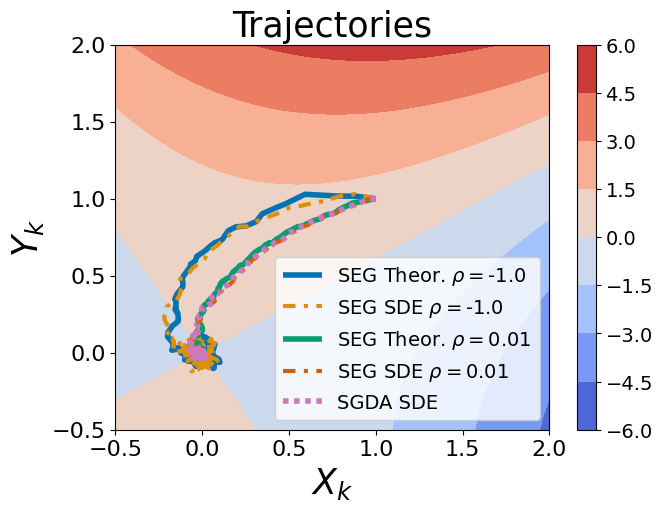

In [14]:
plt.contourf(X, Y, Z, cmap='coolwarm')  # Adjust the colormap ('cmap') as needed
plt.colorbar()  # Add a colorbar to show the values

i=0
line_1, = plt.plot(avg_EG1s_Real_x[:,i], avg_EG1s_Real_y[:,i], color = colors[0],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_2, = plt.plot(avg_EG1s_SDE_x[:,i], avg_EG1s_SDE_y[:,i], color = colors[1],linewidth=3,linestyle='-', dashes=custom_dashes[3])
line_3, = plt.plot(avg_EG2s_Real_x[:,i], avg_EG2s_Real_y[:,i], color = colors[2],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_4, = plt.plot(avg_EG2s_SDE_x[:,i], avg_EG2s_SDE_y[:,i], color = colors[3],linewidth=3,linestyle='-', dashes=custom_dashes[3])
line_5, = plt.plot(avg_GDAs_SDE_x[:,i], avg_GDAs_SDE_y[:,i], color = colors[4],linewidth=4,linestyle='-', dashes=custom_dashes[1])

plt.legend([line_1, line_2, line_3, line_4, line_5], [r'SEG Theor. $ \rho=$' + str(rho1),r'SEG SDE $\rho=$' + str(rho1),r'SEG Theor. $ \rho=$' + str(rho2),r'SEG SDE $\rho=$' + str(rho2),'SGDA SDE'],fontsize=14)
plt.title("Trajectories",fontsize=25)
plt.xlabel(r'$X_k$',fontsize=25)
plt.ylabel(r'$Y_k$',fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

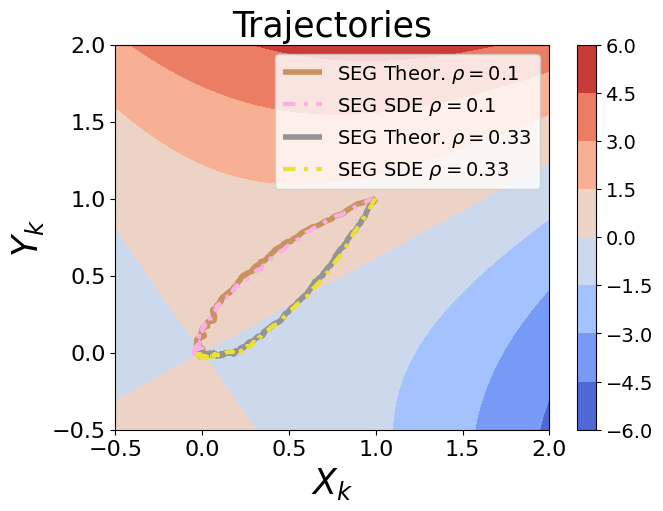

In [15]:
plt.contourf(X, Y, Z, cmap='coolwarm')  # Adjust the colormap ('cmap') as needed
plt.colorbar()  # Add a colorbar to show the values


line_1, = plt.plot(avg_EG3s_Real_x[:,i], avg_EG3s_Real_y[:,i], color = colors[5],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_2, = plt.plot(avg_EG3s_SDE_x[:,i], avg_EG3s_SDE_y[:,i], color = colors[6],linewidth=3,linestyle='-', dashes=custom_dashes[3])
line_3, = plt.plot(avg_EG4s_Real_x[:,i], avg_EG4s_Real_y[:,i], color = colors[7],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_4, = plt.plot(avg_EG4s_SDE_x[:,i], avg_EG4s_SDE_y[:,i], color = colors[8],linewidth=3,linestyle='-', dashes=custom_dashes[3])

plt.legend([line_1, line_2, line_3, line_4], [r'SEG Theor. $ \rho=$' + str(rho3),r'SEG SDE $\rho=$' + str(rho3),r'SEG Theor. $ \rho=$' + str(rho4),r'SEG SDE $\rho=$' + str(rho4)],fontsize=14)
plt.title("Trajectories",fontsize=25)
plt.xlabel(r'$X_k$',fontsize=25)
plt.ylabel(r'$Y_k$',fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [16]:
ni_EG1_Real = many_norm_iterates(EG1s_Real_x, EG1s_Real_y)
ni_EG1_SDE = many_norm_iterates(EG1s_SDE_x, EG1s_SDE_y)
ni_EG2_Real = many_norm_iterates(EG2s_Real_x, EG2s_Real_y)
ni_EG2_SDE = many_norm_iterates(EG2s_SDE_x, EG2s_SDE_y)

ni_EG3_Real = many_norm_iterates(EG3s_Real_x, EG3s_Real_y)
ni_EG3_SDE = many_norm_iterates(EG3s_SDE_x, EG3s_SDE_y)
ni_EG4_Real = many_norm_iterates(EG4s_Real_x, EG4s_Real_y)
ni_EG4_SDE = many_norm_iterates(EG4s_SDE_x, EG4s_SDE_y)

ni_GDA_SDE = many_norm_iterates(GDAs_SDE_x, GDAs_SDE_y)

In [17]:
avg_norm_iter_EG1_Real = np.mean(ni_EG1_Real,axis=0)
std_norm_iter_EG1_Real = np.std(ni_EG1_Real,axis=0)

avg_norm_iter_EG1_SDE = np.mean(ni_EG1_SDE,axis=0)
std_norm_iter_EG1_SDE = np.std(ni_EG1_SDE,axis=0)

avg_norm_iter_EG2_Real = np.mean(ni_EG2_Real,axis=0)
std_norm_iter_EG2_Real = np.std(ni_EG2_Real,axis=0)

avg_norm_iter_EG2_SDE = np.mean(ni_EG2_SDE,axis=0)
std_norm_iter_EG2_SDE = np.std(ni_EG2_SDE,axis=0)

avg_norm_iter_EG3_Real = np.mean(ni_EG3_Real,axis=0)
std_norm_iter_EG3_Real = np.std(ni_EG3_Real,axis=0)

avg_norm_iter_EG3_SDE = np.mean(ni_EG3_SDE,axis=0)
std_norm_iter_EG3_SDE = np.std(ni_EG3_SDE,axis=0)

avg_norm_iter_EG4_Real = np.mean(ni_EG4_Real,axis=0)
std_norm_iter_EG4_Real = np.std(ni_EG4_Real,axis=0)

avg_norm_iter_EG4_SDE = np.mean(ni_EG4_SDE,axis=0)
std_norm_iter_EG4_SDE = np.std(ni_EG4_SDE,axis=0)


avg_norm_iter_GDA_SDE = np.mean(ni_GDA_SDE,axis=0)
std_norm_iter_GDA_SDE = np.std(ni_GDA_SDE,axis=0)

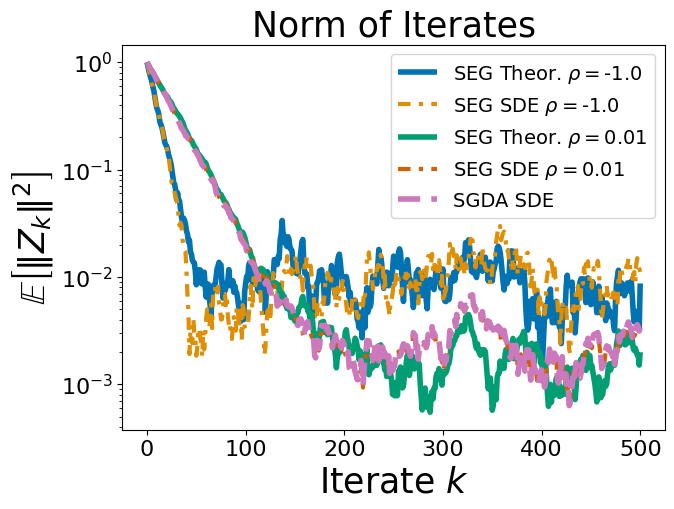

In [18]:
plt.figure()


line_1, = plt.plot(avg_norm_iter_EG1_Real, color = colors[0],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_2, = plt.plot(avg_norm_iter_EG1_SDE, color = colors[1],linewidth=3,linestyle='-', dashes=custom_dashes[3])
line_3, = plt.plot(avg_norm_iter_EG2_Real, color = colors[2],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_4, = plt.plot(avg_norm_iter_EG2_SDE, color = colors[3],linewidth=3,linestyle='-', dashes=custom_dashes[3])
line_5, = plt.plot(avg_norm_iter_GDA_SDE, color = colors[4],linewidth=4,linestyle='-', dashes=custom_dashes[2])


plt.legend([line_1, line_2, line_3, line_4, line_5], [r'SEG Theor. $ \rho=$' + str(rho1),r'SEG SDE $\rho=$' + str(rho1),r'SEG Theor. $ \rho=$' + str(rho2),r'SEG SDE $\rho=$' + str(rho2),'SGDA SDE'],fontsize=14)
plt.title("Norm of Iterates",fontsize=25)
plt.xlabel(r'Iterate $k$',fontsize=25)
plt.ylabel(r'$\mathbb{E}\left[\|Z_k\|^2\right]$',fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.show()

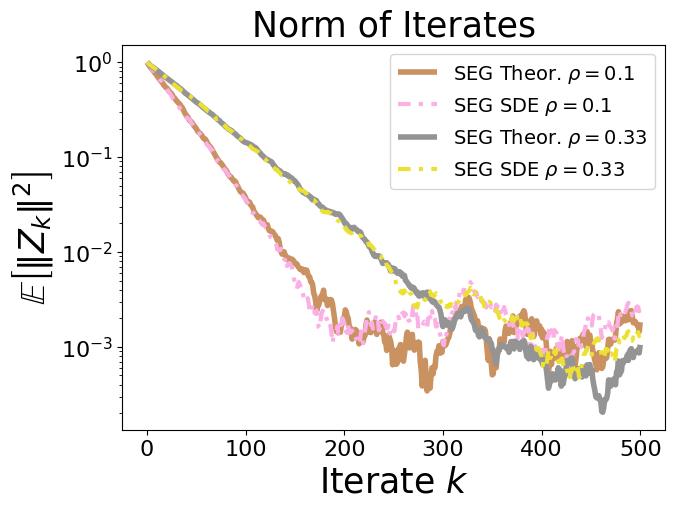

In [19]:
plt.figure()


line_1, = plt.plot(avg_norm_iter_EG3_Real, color = colors[5],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_2, = plt.plot(avg_norm_iter_EG3_SDE, color = colors[6],linewidth=3,linestyle='-', dashes=custom_dashes[3])
line_3, = plt.plot(avg_norm_iter_EG4_Real, color = colors[7],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_4, = plt.plot(avg_norm_iter_EG4_SDE, color = colors[8],linewidth=3,linestyle='-', dashes=custom_dashes[3])

plt.legend([line_1, line_2, line_3, line_4], [r'SEG Theor. $ \rho=$' + str(rho3),r'SEG SDE $\rho=$' + str(rho3),r'SEG Theor. $ \rho=$' + str(rho4),r'SEG SDE $\rho=$' + str(rho4)],fontsize=14)
plt.title("Norm of Iterates",fontsize=25)
plt.xlabel(r'Iterate $k$',fontsize=25)
plt.ylabel(r'$\mathbb{E}\left[\|Z_k\|^2\right]$',fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.show()

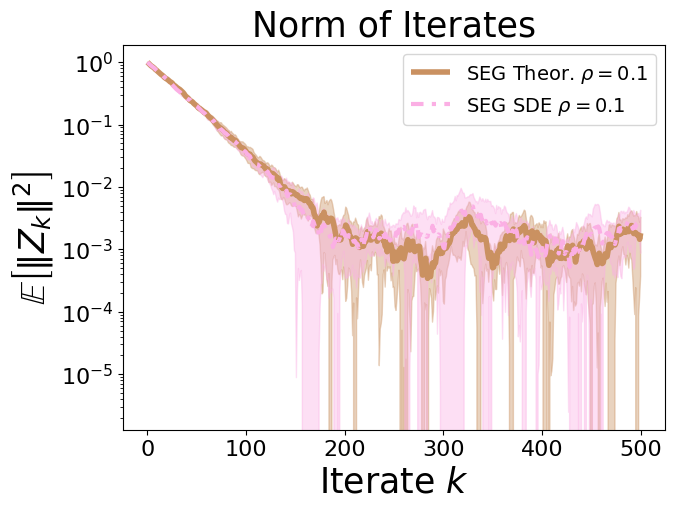

In [20]:
plt.figure()


prop = 1

line_1, = plt.plot(avg_norm_iter_EG3_Real, color = colors[5],linewidth=4,linestyle='-', dashes=custom_dashes[0])
line_2, = plt.plot(avg_norm_iter_EG3_SDE, color = colors[6],linewidth=3,linestyle='-', dashes=custom_dashes[3])

plt.fill_between( np.arange(0, num_iterations + 1), avg_norm_iter_EG3_Real - prop*std_norm_iter_EG3_Real, avg_norm_iter_EG3_Real + prop*std_norm_iter_EG3_Real,
                 color=colors[5], alpha=0.4)

plt.fill_between( np.arange(0, num_iterations + 1),avg_norm_iter_EG3_SDE - prop*std_norm_iter_EG3_SDE, avg_norm_iter_EG3_SDE + prop*std_norm_iter_EG3_SDE,
                 color=colors[6], alpha=0.4)

plt.legend([line_1, line_2], [r'SEG Theor. $ \rho=$' + str(rho3),r'SEG SDE $\rho=$' + str(rho3)],fontsize=14)
plt.title("Norm of Iterates",fontsize=25)
plt.xlabel(r'Iterate $k$',fontsize=25)
plt.ylabel(r'$\mathbb{E}\left[\|Z_k\|^2\right]$',fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.show()